# **"An Application of Convolutional Neural Networks to Music Genre Classification"** 

Contained in this notebook is the code for the models discussed in our report.

## Libraries 

This section contains the library and data calls

It is first necessary to run the chunk below in order to access the `d2l` package.

In [1]:
!pip install d2l==0.17.6
!pip install matplotlib
!pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here we import all python libraries/packages used in our analysis.

In [2]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from d2l import torch as d2l

In order to access our data in Colab, we clone our github repository.

In [3]:
!git clone "https://github.com/BSteiner1/ST311-Group-Project/"

Cloning into 'ST311-Group-Project'...
remote: Enumerating objects: 2228, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 2228 (delta 103), reused 179 (delta 56), pack-reused 1998
Receiving objects: 100% (2228/2228), 1.20 GiB | 23.96 MiB/s, done.
Resolving deltas: 100% (103/103), done.
Updating files: 100% (2028/2028), done.


## Data Loading 

This section contains the loading and augmentation of our data.

### Mel-Spectrograms

We first define our label mappings, this is necessary since our function below depend on the labels being integers.

In [4]:
class_dict = {'blues' : 0,
              'classical': 1,
              'country': 2,
              'disco' : 3,
              'hiphop' : 4,
              'jazz' : 5,
              'metal' : 6,
              'pop' : 7,
              'reggae': 8,
              'rock' : 9    
}

We next define our data collection function.

In [5]:
def collect_data():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("ST311-Group-Project/Data/images_original"):
        for image in os.listdir("ST311-Group-Project/Data/images_original/" + genre):
            image_path = "ST311-Group-Project/Data/images_original/" + genre + "/" + image
            # Convert to grayscale
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Trim the excess white pixels from the image
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            # Convert to tensor
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  
            data.append((grayscale_img.reshape(1,217,335), torch.tensor(class_dict.get(genre))))

    return data      

We then call the function to instantiate our data.

In [6]:
data = collect_data()

For the later models, we found performance improved if we split each photos into 5 slices. So below we define another dataset that contains this

In [123]:
def collect_slice_data():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("ST311-Group-Project/Data/images_original"):
        for image in os.listdir("ST311-Group-Project/Data/images_original/" + genre):
            image_path = "ST311-Group-Project/Data/images_original/" + genre + "/" + image
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)
            # Splitting each image vertically into 5 different parts
            for i in range(5):
                # The data loader adds a dimension so I've removed a dimension from the image and class
                data.append((grayscale_img[ : ,  (67*i):67*(i+1)].reshape(1,217,67), torch.tensor(class_dict.get(genre)))) #.reshape(1)))

    return data     

slice_data = collect_slice_data()      

### Features 

We first define the path to our feature data, and load in our raw feature data.

In [7]:
feature_path = "ST311-Group-Project/Data/features_30_sec - edited.csv"

# Load in the metadata into a DataFrame
raw_df = pd.read_csv(feature_path)

We next perform some data cleaning, and as before convert our labels to integers.

In [8]:
# Remove unnecessary variables for prediction
del raw_df['filename']
del raw_df['length']
# Map the label to a number
raw_df['label'] = raw_df['label'].map(class_dict)

Some of our predictors have vastly different scales, and as such we scale the features to have a mean of 0 and variance of 1.

In [9]:
# Scale each column of the DataFrame to mean 0 variance 1
df = StandardScaler().fit_transform(raw_df.iloc[:, 0:-1])
df = pd.DataFrame(df, columns = raw_df.columns.tolist()[:-1])
df['label'] = raw_df['label']

Finally we transform our data into a suitable format.

In [10]:
# Collect the (metadata, label) tuples and convert to tensors
metadata = [(torch.tensor(list(df.loc[i][:-1])).clone().detach().requires_grad_(True).reshape(1,1,-1), \
             torch.tensor(df['label'][i], dtype=torch.long)) for i in range(len(df))]

### Data Loaders

Here, we split our data and create Data-Loaders that can be fed into our models. Firstly for our mel-spectrogram inputs

In [119]:
# Split our data into train and test sets with an 80:20 split
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

#Define train and test loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

And our sliced data

In [125]:
# Split our data into train and test sets with an 80:20 split
slice_train_size = int(0.8 * len(slice_data))
slice_test_size = len(slice_data) - slice_train_size
slice_train_dataset, slice_test_dataset = torch.utils.data.random_split(slice_data, [slice_train_size, slice_test_size])

#Define train and test loaders
slice_train_loader = DataLoader(slice_train_dataset, batch_size=16, shuffle=True)
slice_test_loader = DataLoader(slice_test_dataset, batch_size=16, shuffle=False)

Next, for our meta-data 

In [120]:
# 80:20 train-test split for our metadata
meta_train_size = int(0.80 * len(metadata))
meta_test_size = len(metadata) - meta_train_size
metadata_train_dataset, metadata_test_dataset = torch.utils.data.random_split(metadata, [meta_train_size, meta_test_size])

# Add to data loaders
metadata_train_loader = DataLoader(metadata_train_dataset, batch_size=40, shuffle=True)
metadata_test_loader = DataLoader(metadata_test_dataset, batch_size=20, shuffle=False)

Later on in our analysis we use ensemble models, and for some of these it is necessary to define a data loader that contains both sets of data.

In [155]:
#Define the joined data
joined_data = [(data[i][0], metadata[i][0], torch.tensor(df['label'][i], dtype=torch.long)) for i in range(len(df))]

#Split with 80:20 split
joined_train_size = int(0.8 * len(joined_data))
joined_test_size = len(joined_data) - joined_train_size
joined_train_dataset, joined_test_dataset = torch.utils.data.random_split(joined_data, [joined_train_size, joined_test_size])

#Define data loaders
joined_train_loader = DataLoader(joined_train_dataset, batch_size=30, shuffle=True)
joined_test_loader = DataLoader(joined_test_dataset, batch_size=30, shuffle=False)

## Base-Line Models

This section contains the definition and training for each of our base-line models. These being the Multi-Layer Perceptron (MLP), the Convolutional Neural Network (CNN), and Recurrent Neural Network (RNN)

### MLP

#### Model Definition

In [14]:
#Our MLP Net
mlp_model = nn.Sequential(
    
    #Flatten the inputs
    nn.Flatten(),

    #(57x32) Fully Connected (FC) Layer, ReLU Activation, Dropout 0.25
    nn.Linear(57, 32), nn.ReLU(), nn.Dropout(0.25),

    #(32,16) FC Layer, ReLU Activation, Dropout 0.25
    nn.Linear(32, 16), nn.ReLU(), nn.Dropout(0.25),

    #(16,10) FC Layer
    nn.Linear(16, 10)

)

#Define our loss function
loss = nn.CrossEntropyLoss()

#Define our optimisation algorithm
trainer = torch.optim.SGD(mlp_model.parameters(), lr=0.1)

#Define our number of epochs
meta_epochs = 50

#### Model Training

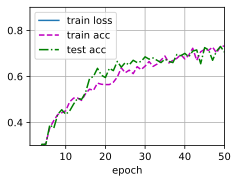

In [15]:
d2l.train_ch3(mlp_model, metadata_train_loader, metadata_test_loader, loss, meta_epochs, trainer)

### CNN

#### Model Definition

In [130]:
#Our CNN 
cnn_net = nn.Sequential(
    
    #16@3x3 Convolutional Layer, ReLU Activation Function
    nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    #3x3 Max Pooling with stride 3 
    nn.MaxPool2d(kernel_size=2, stride=2),

    #32@3x3 Convolutional Layer, ReLU Activation Function
    nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    #3x3 Max Pooling with stride 3 
    nn.MaxPool2d(kernel_size=2, stride=2),

    #64@3x3 Convolutional Layer, ReLU Activation Function
    nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    #3x3 Max Pooling with stride 3 
    nn.MaxPool2d(kernel_size=2, stride=2),

    #128@3x3 Convolutional Layer, ReLU Activation Function
    nn.Conv2d(64,128, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    #3x3 Max Pooling with stride 3 
    nn.MaxPool2d(kernel_size = 4, stride = 4),

    #64@3x3 Convolutional Layer, ReLU Activation Function
    nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    #Flatten Layers
    nn.Flatten(),

    #512x64 FC Layer, Dropout 0.2, ReLU Activation
    nn.Linear(768, 64), nn.Dropout(0.2), nn.ReLU(),

    #64x10 FC Layer
    nn.Linear(64,10)

)

#Define training parameters
cnn_epochs = 50
cnn_lr = 0.01

#### Model Training

loss 0.443, train acc 0.848, test acc 0.677
1930.5 examples/sec on cuda:0


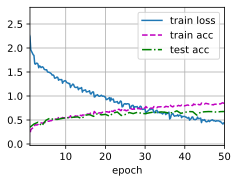

In [131]:
d2l.train_ch6(cnn_net, slice_train_loader, slice_test_loader, cnn_epochs, cnn_lr, d2l.try_gpu())

### RNN

#### Model Definition

We first define the model class

In [135]:
#Define RNN
class rnn_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(rnn_net, self).__init__()

        #Hidden dimensions
        self.hidden_dim = hidden_dim

        #Number of hidden layers
        self.layer_dim = layer_dim

        #Bi-GRU Layer 
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional = True)
  
        #hidden_dim x output_dim FC Layer
        self.fc = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, x):

        #Initialize hidden state with zeros
        # to.('cuda') ensures the hidden and input tensors are GPU
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().to('cuda')

        #RNN Foward Step
        out, hn = self.gru(x, h0.detach())

        #Clips off final hidden state 
        out = self.fc(out[:, -1, :]) 

        return out

Then we instantiate the model 

In [138]:
#Define our structural parameters
input_dim = 217
hidden_dim = 64
layer_dim = 2
output_dim = 10

#Define instance of model
rnn_model = rnn_net(input_dim, hidden_dim, layer_dim, output_dim).to('cuda')

#Define model functions
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.0001)
rnn_loss = nn.CrossEntropyLoss()

#Define epochs
rnn_epochs = 20

#### Model Training

In [139]:
# Number of steps to unroll
seq_dim = 67 

iter = 0
for epoch in range(rnn_epochs):
    for i, (images, labels) in enumerate(slice_train_loader):

        images = images.to('cuda')
        labels = labels.to('cuda')

        rnn_model.train()

        #Load spectrograms as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        #Clear gradients
        rnn_optimizer.zero_grad()

        #Forward pass 
        outputs = rnn_model(images)

        #Calculate Loss
        loss = rnn_loss(outputs, labels)

        #Backward Pass
        loss.backward()

        #Update
        rnn_optimizer.step()

        iter += 1

        if iter % 500 == 0:
            rnn_model.eval()

            #Calculate Accuracy

            correct = 0
            total = 0

            # Iterate through test dataset
            for images, labels in slice_test_loader:

                images = images.to('cuda')
                labels = labels.to('cuda')
                
                #Load spectrograms as tensors
                images = images.view(-1, seq_dim, input_dim)

                # Forward pass 
                outputs = rnn_model(images)

                #Get predictions
                _, predicted = torch.max(outputs.data, 1)

                #Total number of genres
                total += labels.size(0)

                #Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 500. Loss: 2.1635451316833496. Accuracy: 23.123123168945312
Iteration: 1000. Loss: 2.030060052871704. Accuracy: 27.82782745361328
Iteration: 1500. Loss: 1.8222657442092896. Accuracy: 29.929929733276367
Iteration: 2000. Loss: 1.8253898620605469. Accuracy: 31.031030654907227
Iteration: 2500. Loss: 1.4022310972213745. Accuracy: 35.135135650634766
Iteration: 3000. Loss: 1.5719189643859863. Accuracy: 35.935935974121094
Iteration: 3500. Loss: 1.6693650484085083. Accuracy: 37.737735748291016
Iteration: 4000. Loss: 1.2320109605789185. Accuracy: 37.13713836669922
Iteration: 4500. Loss: 1.335000991821289. Accuracy: 38.438438415527344
Iteration: 5000. Loss: 1.834577202796936. Accuracy: 38.838836669921875


## Ensemble Models

This section contains the definition and training of our ensemble models, namely the CNN-MLP and the CNN-RNN

### CNN-MLP

#### Model Adjustments

During our model development, it became clear that each baseline model would have to be carefully adjusted in order to fit each other in an ensemble. Below are the adjustments we made to each the CNN and the MLP before we define the ensemble. (Changes occur in commented layers)

In [156]:
#Adjusted MLP

e_mlp = nn.Sequential(
    
    nn.Flatten(),

    #57x128 FC Layer, ReLU Activation Layer
    nn.Linear(57, 128), nn.ReLU(),

    #128x128 FC Layer, ReLU Activation Layer
    nn.Linear(128, 128),nn.ReLU(),

    #128x100 FC Layer
    nn.Linear(128, 100) 
)

#Adjusted CNN 

e_cnn = nn.Sequential(
    
    nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64,128, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    #4x4 Max Pooling Layer with stride 3
    nn.MaxPool2d(kernel_size = 4, stride = 4),

    #256@3x3 Convolution Layer, ReLU Activation
    nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(), 

    nn.Flatten(),

    #15360 x 128 FC Layer, Dropout 0.2, ReLU Activation
    nn.Linear(15360, 128), nn.Dropout(0.2), nn.ReLU(), 

    #128x100, Dropout 0.2, ReLU Activation
    nn.Linear(128, 100), nn.Dropout(0.2), nn.ReLU(),

)

#### Model Definition

In [157]:
#Ensemble Definition

class cnn_mlp(nn.Module):
    def __init__(self):
        super(cnn_mlp, self).__init__()

        #Net to process images
        self.e_cnn = e_cnn

        #Net to process features
        self.e_mlp = e_mlp

        #200x100 FC Layer
        self.fc1 = nn.Linear(200, 100)

        #100x10 FC Layer
        self.fc2 = nn.Linear(100,10)

    def forward(self, x1, x2):

        #Pass image through first subnetwork
        out1 = self.e_cnn(x1)

        #Pass features through second subnetwork
        out2 = self.e_mlp(x2)

        #Concatenate
        out = torch.cat((out1, out2), dim = 1)
        
        #Pass through linear layers
        x = self.fc1(out)
        x = self.fc2(x)

        return x

#Define Model Parameters

cnn_mlp = cnn_mlp().to('cuda')

cnn_mlp_optimizer = torch.optim.Adam(cnn_mlp.parameters(), lr=0.0001)
cnn_mlp_loss = nn.CrossEntropyLoss()

cnn_mlp_epochs = 25

#### Model Training

In [158]:
#Training Loop

for epoch in range(cnn_mlp_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs1, inputs2, targets) in enumerate(joined_train_loader):
      
        #Moves inputs to the gpu
        inputs1 = inputs1.to('cuda')
        inputs2 = inputs2.to('cuda')
        targets = targets.to('cuda')

        # Zero the gradients
        cnn_mlp_optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn_mlp(inputs1, inputs2)
        loss = cnn_mlp_loss(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        cnn_mlp_optimizer.step()
        
        # Compute running loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    # Compute validation loss and accuracy
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs1, inputs2, targets in joined_test_loader:

            #Moves inputs to gpu
            inputs1 = inputs1.to('cuda')
            inputs2 = inputs2.to('cuda')
            targets = targets.to('cuda')
            
            outputs = cnn_mlp(inputs1, inputs2)
            loss = cnn_mlp_loss(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    # Print epoch statistics
    print('Epoch %d: Train Loss: %.3f | Train Acc: %.3f%% | Val Loss: %.3f | Val Acc: %.3f%%'
          % (epoch+1, running_loss/len(joined_train_loader), 100*correct/total,
             val_loss/len(joined_test_loader), 100*val_correct/val_total))

Epoch 1: Train Loss: 2.286 | Train Acc: 14.018% | Val Loss: 2.229 | Val Acc: 21.500%
Epoch 2: Train Loss: 2.110 | Train Acc: 22.904% | Val Loss: 2.051 | Val Acc: 25.500%
Epoch 3: Train Loss: 1.890 | Train Acc: 33.542% | Val Loss: 1.818 | Val Acc: 38.500%
Epoch 4: Train Loss: 1.679 | Train Acc: 41.176% | Val Loss: 1.635 | Val Acc: 47.000%
Epoch 5: Train Loss: 1.436 | Train Acc: 49.687% | Val Loss: 1.397 | Val Acc: 53.500%
Epoch 6: Train Loss: 1.265 | Train Acc: 57.071% | Val Loss: 1.217 | Val Acc: 63.500%
Epoch 7: Train Loss: 1.064 | Train Acc: 66.208% | Val Loss: 1.096 | Val Acc: 62.500%
Epoch 8: Train Loss: 0.967 | Train Acc: 67.334% | Val Loss: 1.151 | Val Acc: 61.500%
Epoch 9: Train Loss: 0.862 | Train Acc: 71.840% | Val Loss: 0.906 | Val Acc: 67.500%
Epoch 10: Train Loss: 0.807 | Train Acc: 73.467% | Val Loss: 0.867 | Val Acc: 71.500%
Epoch 11: Train Loss: 0.679 | Train Acc: 78.723% | Val Loss: 0.816 | Val Acc: 74.000%
Epoch 12: Train Loss: 0.657 | Train Acc: 77.972% | Val Loss: 0.

### CNN-RNN

#### Adjusted Models 

Once again, in order to maximise our predictive performance, we adjusted our RNN model so it can fit in the ensemble. (Changes are commented):

In [171]:
#Adjusted cnn

e2_cnn_net = nn.Sequential(
    
    nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64,128, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    nn.MaxPool2d(kernel_size = 4, stride = 4),

    nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = "same"), nn.Dropout(0.2), nn.ReLU(),

    nn.Flatten(),

    #768x128 FC Layer, Dropout 0.2, ReLU Activation
    nn.Linear(768, 384), nn.Dropout(0.2), nn.ReLU(),

    #384x128 FC Layer
    nn.Linear(384,128)

)

##Adjusted rnn 

class e_rnn_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(e_rnn_net, self).__init__()

        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim

        #Now not bi-directional
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to('cuda')

        out, hn = self.gru(x, h0.detach())

        out = self.fc(out[:, -1, :]) 

        return out

#Define RNN Structural Parameters
seq_input_dim = 1
seq_hidden_dim = 128
seq_layer_dim = 3
seq_output_dim = 10

#Define instance of RNN
seq_rnn_model = e_rnn_net(seq_input_dim, seq_hidden_dim, seq_layer_dim, seq_output_dim).to('cuda')

#### Model Definition 

In [172]:
#Sequential Ensemble Definition

class seq_cnn_rnn(nn.Module):
    def __init__(self):
        super(seq_cnn_rnn, self).__init__()

        #Net to process images
        self.e2_cnn = e2_cnn_net

        #Net to process features
        self.rnn = seq_rnn_model

        #Final (10x10) linear layer
        self.fc1 = nn.Linear(10, 10)

    def forward(self, x):

        #Pass image through cnn
        cnn_out = self.e2_cnn(x)

        #Reshape for RNN
        seq_dim = 128
        input_dim = 1 

        cnn_out = cnn_out.view(-1, seq_dim, input_dim).requires_grad_()

        #Pass features through rnn
        rnn_out = self.rnn(cnn_out)
        
        #Pass through linear layer
        out = self.fc1(rnn_out)

        return out

#Define instance of CNN-RNN
seq_cnn_rnn = seq_cnn_rnn().to('cuda')

#Define model functions
seq_cnn_rnn_optimizer = torch.optim.Adam(seq_cnn_rnn.parameters(), lr=0.0001)
seq_cnn_rnn_loss = nn.CrossEntropyLoss()

#Define epochs
seq_cnn_rnn_epochs = 35

#### Model Training

In [173]:
#Training Loop

for epoch in range(seq_cnn_rnn_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(slice_train_loader):
      
        #Moves inputs to the gpu
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')

        # Zero the gradients
        seq_cnn_rnn_optimizer.zero_grad()
        
        # Forward pass
        outputs = seq_cnn_rnn(inputs)
        loss = seq_cnn_rnn_loss(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        seq_cnn_rnn_optimizer.step()
        
        # Compute running loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    # Compute validation loss and accuracy
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in slice_test_loader:

            #Moves inputs to gpu
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            outputs = seq_cnn_rnn(inputs)
            loss = seq_cnn_rnn_loss(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    # Print epoch statistics
    print('Epoch %d: Train Loss: %.3f | Train Acc: %.3f%% | Val Loss: %.3f | Val Acc: %.3f%%'
          % (epoch+1, running_loss/len(slice_train_loader), 100*correct/total,
             val_loss/len(slice_test_loader), 100*val_correct/val_total))

Epoch 1: Train Loss: 2.272 | Train Acc: 13.288% | Val Loss: 2.173 | Val Acc: 20.320%
Epoch 2: Train Loss: 2.068 | Train Acc: 26.026% | Val Loss: 1.945 | Val Acc: 29.229%
Epoch 3: Train Loss: 1.868 | Train Acc: 31.256% | Val Loss: 1.819 | Val Acc: 33.433%
Epoch 4: Train Loss: 1.716 | Train Acc: 40.591% | Val Loss: 1.670 | Val Acc: 40.541%
Epoch 5: Train Loss: 1.591 | Train Acc: 44.770% | Val Loss: 1.603 | Val Acc: 43.143%
Epoch 6: Train Loss: 1.502 | Train Acc: 48.574% | Val Loss: 1.532 | Val Acc: 48.448%
Epoch 7: Train Loss: 1.432 | Train Acc: 51.727% | Val Loss: 1.433 | Val Acc: 50.951%
Epoch 8: Train Loss: 1.349 | Train Acc: 55.455% | Val Loss: 1.422 | Val Acc: 51.251%
Epoch 9: Train Loss: 1.287 | Train Acc: 57.107% | Val Loss: 1.338 | Val Acc: 55.255%
Epoch 10: Train Loss: 1.247 | Train Acc: 58.233% | Val Loss: 1.327 | Val Acc: 56.256%
Epoch 11: Train Loss: 1.186 | Train Acc: 60.911% | Val Loss: 1.314 | Val Acc: 54.555%
Epoch 12: Train Loss: 1.131 | Train Acc: 62.563% | Val Loss: 1.